<a href="https://colab.research.google.com/github/suinkangme/comp433_project/blob/main/Final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Developing a robust CNN model to address the challenge of learning with label noise in  CIFAR10 dataset

- CIFAR10 Label : ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’.

- image size : 3x32x32




In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, random_split

import time
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler

In [ ]:
seed = 10
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

## Load and normalize CIFAR10

- Transform them to Tensors of normalized range [-1, 1].

In [ ]:
# imagenet
imagenet_mean = (0.485, 0.456, 0.406)
imagenet_std = (0.229, 0.224, 0.225)


# Training transformations
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

# Validation and testing transformations
transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

In [ ]:
seed = 10
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)


# download dataset for training
cifar_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=None)

# index for val and train data
dataset_size = len(cifar_dataset)
validation_split = 0.2
val_size = int(validation_split * dataset_size)
train_size = dataset_size - val_size

# split data
train_dataset, val_dataset = random_split(cifar_dataset, [train_size, val_size])

# transform
train_dataset.dataset.transform = transform_train
val_dataset.dataset.transform = transform_val

# data loader
batch_size = 512
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


100%|██████████| 170498071/170498071 [00:11<00:00, 14879529.27it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
# test dataset
test_dataset = torchvision.datasets.CIFAR10(root='./data',
                                          train=False,
                                          download=True,
                                          transform = transform_test)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified


In [ ]:
class_names = cifar_dataset.classes
print(class_names)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## Noise Labeling
- 4 different noise levels (10%,
30%, 60%, 90%)

In [ ]:
def apply_label_noise(labels, epsilon, noise_type):
    seed = 10
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)

    num_labels = len(labels)
    num_flips = int(epsilon * num_labels)

    if noise_type == 'symmetric':
        # symmetric label noise
        flip_indices = np.random.choice(num_labels, num_flips, replace=False)
        labels[flip_indices] = np.random.randint(0, 10, num_flips)

    elif noise_type == 'asymmetric':
        # asymmetric label noise
        flip_rules = {
            9: 1,   # Truck to Automobile
            2: 0,   # Bird to Airplane
            4: 7,   # Deer to Horse
            3: 5,   # Cat to Dog
            5: 3,   # Dog to Cat
        }

        for i in range(num_labels):
            if np.random.random() < epsilon:
                labels[i] = flip_rules.get(labels[i], labels[i])

    return labels

### hyperparameter

In [ ]:
# hyperparameter
num_epochs = 7
noise_levels = [0.0, 0.1, 0.3, 0.6, 0.9]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Baseline Model

In [ ]:
class BaselineModel(nn.Module):
  def __init__(self):
    super(BaselineModel,self).__init__()
    self.features = nn.Sequential(
      nn.Conv2d(3, 8, kernel_size=3, padding = 1),  # (input channel, output channels, kernel size, padding)  32*32*8
      nn.ReLU(inplace=True), # activation function modifies the input tensor directly
      nn.Conv2d(8, 16, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2,stride=2), # 16*16*16

      nn.Conv2d(16, 32, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(32, 64, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(64, 128, kernel_size=3, padding=1),
      nn.MaxPool2d(kernel_size=2,stride=2) # 8*8*128
    )

    # fully connected layers
    self.fc_layers = nn.Sequential(
      nn.Linear(128*8*8, 512),
      nn.ReLU(inplace=True),
      nn.Linear(512,10)
    )

    # apply Xavier initialization to the weights of linear layers
    for m in self.fc_layers:
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)

  def forward(self, x):
    x = self.features(x)
    x = torch.flatten(x,1)
    x = self.fc_layers(x)
    return x

### Function to plot validation loss & train accuracy


In [ ]:
# plot validation loss & accuracy for each noise level

def plot_validation_loss_and_train_accuracy(validation_losses,train_accuracies):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    for epsilon, losses in validation_losses.items():
        plt.plot(losses, label=f'Noise Level {epsilon}', marker='o')

    plt.title('validation Loss vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('validation Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    for epsilon, accuracies in train_accuracies.items():
        plt.plot(accuracies, label=f'Noise Level {epsilon}', marker='o')

    plt.title('Training Accuracy vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Training Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()



### Function to plot test accuracy comparison

In [ ]:
def plot_test_accuracy_compare(my_test_accuracies,base_test_accuracies ,model_name, noise_levels=noise_levels):
    plt.figure(figsize=(6, 4))

    # Your data
    categories = noise_levels
    data_set1 = base_test_accuracies
    data_set2 = my_test_accuracies

    # Narrower bar width
    bar_width = 0.2

    # Set up positions for the categories
    bar_positions_set1 = range(len(categories))
    bar_positions_set2 = [pos + bar_width for pos in bar_positions_set1]

    # Create bar chart
    plt.bar(bar_positions_set1, data_set1, width=bar_width, label='Baseline')
    plt.bar(bar_positions_set2, data_set2, width=bar_width, label= model_name)

    # Customize the chart
    plt.title('Testing Accuracy vs. Noise Level ()')
    plt.xlabel('Noise Level')
    plt.ylabel('Accuracy (%)')
    plt.xticks([pos + bar_width / 2 for pos in bar_positions_set1], categories)
    plt.legend()

    plt.ylim(bottom=15)

    # Show the chart
    plt.show()

### Function to print test output

In [ ]:
def print_test_output(model_dict):
    test_accuracies = []
    testing_times = []

    for key, net in model_dict.items():
        net.eval()

        # Variables to store values
        num_correct_predictions = 0
        total_num_predictions = 0
        loss = 0.0


        # initialize variables to measure testing time
        start_time_test = time.time()

        # Iterate over the test dataset
        with torch.no_grad():  # temporarily set all requires_grad flags to False
            for i, (data, label) in enumerate(test_loader):
                # move inputs to desired device and dtype
                data = data.to(device, dtype=torch.float32)
                label = label.to(device, dtype=torch.long)

                # forward pass
                logit = net(data)

                # compute loss and number of accurate predictions
                loss += torch.nn.functional.cross_entropy(logit, label, reduction='sum').item()
                preds = logit.max(dim=1)[1]
                num_correct_predictions += (preds == label).sum().item()
                total_num_predictions += len(preds)


        # measure testing time
        total_test_time = time.time() - start_time_test
        testing_times.append(total_test_time)

        # compute average loss
        loss /= total_num_predictions

        # compute accuracy percentage
        accuracy = (float(num_correct_predictions) / total_num_predictions) * 100
        test_accuracies.append(accuracy)

        print(f"{key} Accuracy: {accuracy:.2f}%, Loss: {loss:.4f} Testing Time: {total_test_time:.2f} seconds")
    return test_accuracies,testing_times

## Training baseline model - 20 epochs

In [ ]:
base_model = BaselineModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(base_model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=120) # Learning rate scheduler (cosine annealing)


In [ ]:


num_epochs=20
val_losses = []

for epoch in range(num_epochs):
    # Training
    base_model.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        # Move data to GPU
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = base_model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    average_train_loss = total_train_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train


    # Update learning rate
    scheduler.step()


    # Validation
    base_model.eval()
    total_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            # Move data to GPU
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = base_model(inputs)
            loss = criterion(outputs, labels)

            total_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    average_val_loss = total_val_loss / len(val_loader)
    val_acc = 100 * correct_val / total_val

    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Train Loss: {average_train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, '
          f'Validation Loss: {average_val_loss:.4f}, Validation Accuracy: {val_acc:.2f}')

    val_losses.append(average_val_loss)


Epoch 1/20, Train Loss: 2.1031, Train Accuracy: 22.02%, Validation Loss: 1.8693, Validation Accuracy: 32.50
Epoch 2/20, Train Loss: 1.6978, Train Accuracy: 40.07%, Validation Loss: 1.6242, Validation Accuracy: 42.02
Epoch 3/20, Train Loss: 1.4627, Train Accuracy: 47.88%, Validation Loss: 1.4210, Validation Accuracy: 49.26
Epoch 4/20, Train Loss: 1.3163, Train Accuracy: 53.36%, Validation Loss: 1.3295, Validation Accuracy: 53.11
Epoch 5/20, Train Loss: 1.2081, Train Accuracy: 57.34%, Validation Loss: 1.2348, Validation Accuracy: 56.60
Epoch 6/20, Train Loss: 1.0979, Train Accuracy: 61.31%, Validation Loss: 1.1945, Validation Accuracy: 58.18
Epoch 7/20, Train Loss: 1.0110, Train Accuracy: 64.64%, Validation Loss: 1.1459, Validation Accuracy: 59.92
Epoch 8/20, Train Loss: 0.9176, Train Accuracy: 67.87%, Validation Loss: 1.1430, Validation Accuracy: 61.48
Epoch 9/20, Train Loss: 0.8193, Train Accuracy: 71.57%, Validation Loss: 1.0991, Validation Accuracy: 62.18
Epoch 10/20, Train Loss: 0.7

### Plot validation loss for basline - 20 epochs

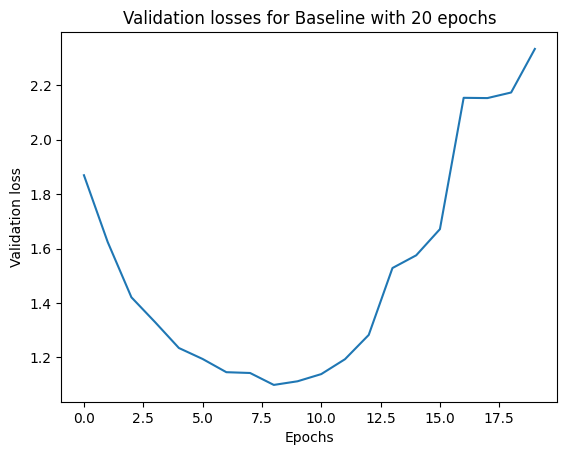

In [ ]:
# Create a plot
plt.plot(val_losses)
x_values = range(1, 21)

# Add labels and title if needed
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.title('Validation losses for Baseline with 20 epochs')

# Show the plot
plt.show()


## Train, Validation and Testing - symmetric noise label - Baseline

In [ ]:
num_epochs=7

In [ ]:

train_losses = {epsilon: [] for epsilon in noise_levels}
train_accuracies = {epsilon: [] for epsilon in noise_levels}
val_losses = {epsilon: [] for epsilon in noise_levels}
val_accuracies = {epsilon: [] for epsilon in noise_levels}
base_sym_training_times = {epsilon: [] for epsilon in noise_levels}


# Create a dictionary for models
base_symmetric_model_dict = {f'noise_level_{int(100 * level)}_sy': None for level in noise_levels}

print("Training with Baseline Model")

for epsilon in noise_levels:
    # Define different model for each nose level
    net = BaselineModel().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=120) # Learning rate scheduler (cosine annealing)

    # traning time for each noise level
    running_time = 0

    print(f"Symmetric Training with noise level: {epsilon}")

    for epoch in range(num_epochs):
        # Training
        net.train()
        total_train_loss = 0.0
        correct_train = 0
        total_train = 0

        # initialize variables to measure training time
        start_time_train = time.time()


        for inputs, labels in train_loader:
            labels_noisy = torch.from_numpy(apply_label_noise(labels.numpy(), epsilon=epsilon, noise_type='symmetric'))

            # Move data to GPU
            inputs, labels_noisy = inputs.to(device), labels_noisy.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = net(inputs)
            loss = criterion(outputs, labels_noisy)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels_noisy.size(0)
            correct_train += (predicted == labels_noisy).sum().item()

        # epoch training time
        epoch_time = time.time() - start_time_train

        running_time = running_time +epoch_time
        base_sym_training_times[epsilon].append(running_time)


        average_train_loss = total_train_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train

        # store training metrics
        train_losses[epsilon].append(average_train_loss)
        train_accuracies[epsilon].append(train_acc)


        # update learning rate
        scheduler.step()

        # Validation
        net.eval()
        total_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                # Move data to GPU
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = net(inputs)
                loss = criterion(outputs, labels)

                total_val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        average_val_loss = total_val_loss / len(val_loader)
        val_acc = 100 * correct_val / total_val

        # store validation metrics
        val_losses[epsilon].append(average_val_loss)
        val_accuracies[epsilon].append(val_acc)

        print(f'Epoch {epoch + 1}/{num_epochs}, '
              f'Train Loss: {average_train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, '
              f'Validation Loss: {average_val_loss:.4f}, Validation Accuracy: {val_acc:.2f}')

        # save model to dictionary
        base_symmetric_model_dict[f'noise_level_{int(100 * epsilon)}_sy'] = net
    print(f'Training Time for {epsilon} : {running_time:.2f} seconds')


Training with Baseline Model
Symmetric Training with noise level: 0.0
Epoch 1/7, Train Loss: 2.2042, Train Accuracy: 19.73%, Validation Loss: 2.0315, Validation Accuracy: 26.81
Epoch 2/7, Train Loss: 1.7637, Train Accuracy: 37.15%, Validation Loss: 1.6064, Validation Accuracy: 42.20
Epoch 3/7, Train Loss: 1.4781, Train Accuracy: 47.60%, Validation Loss: 1.4892, Validation Accuracy: 47.36
Epoch 4/7, Train Loss: 1.3235, Train Accuracy: 52.80%, Validation Loss: 1.3609, Validation Accuracy: 52.29
Epoch 5/7, Train Loss: 1.1995, Train Accuracy: 57.62%, Validation Loss: 1.2452, Validation Accuracy: 56.60
Epoch 6/7, Train Loss: 1.0869, Train Accuracy: 61.42%, Validation Loss: 1.1680, Validation Accuracy: 59.32
Epoch 7/7, Train Loss: 0.9776, Train Accuracy: 65.53%, Validation Loss: 1.1489, Validation Accuracy: 60.59
Training Time for 0.0 : 94.05 seconds
Symmetric Training with noise level: 0.1
Epoch 1/7, Train Loss: 2.2005, Train Accuracy: 18.71%, Validation Loss: 1.9735, Validation Accuracy: 2

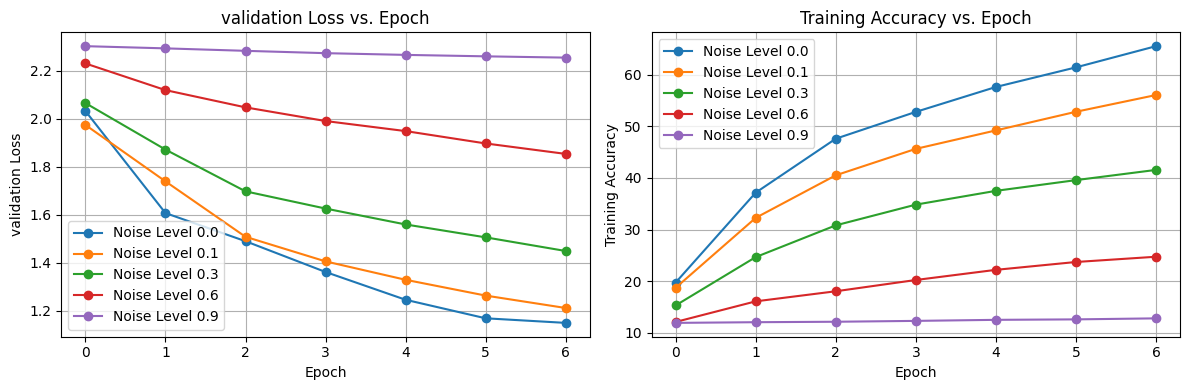

In [ ]:
plot_validation_loss_and_train_accuracy(val_losses,train_accuracies)

In [ ]:
base_sym_test_accuracies,base_sym_testing_times = print_test_output(base_symmetric_model_dict)

noise_level_0_sy Accuracy: 61.15%, Loss: 1.1248 Testing Time: 2.66 seconds
noise_level_10_sy Accuracy: 58.53%, Loss: 1.2027 Testing Time: 2.76 seconds
noise_level_30_sy Accuracy: 53.21%, Loss: 1.4376 Testing Time: 2.68 seconds
noise_level_60_sy Accuracy: 45.08%, Loss: 1.8422 Testing Time: 2.69 seconds
noise_level_90_sy Accuracy: 15.34%, Loss: 2.2548 Testing Time: 2.67 seconds


## Train & Validation and Testing - asymmetric noise label -Baseline

In [ ]:

train_losses = {epsilon: [] for epsilon in noise_levels}
train_accuracies = {epsilon: [] for epsilon in noise_levels}
val_losses = {epsilon: [] for epsilon in noise_levels}
val_accuracies = {epsilon: [] for epsilon in noise_levels}
base_asyn_training_times = {epsilon: [] for epsilon in noise_levels}


# Create a dictionary with keys in the format 'noise_level_{100 * value}'
base_asymmetric_model_dict = {f'noise_level_{int(100 * level)}_asy': None for level in noise_levels}

print("Training with Baseline Model")


for epsilon in noise_levels:


    # Define different model for each nose level
    net = BaselineModel().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=120) # Learning rate scheduler (cosine annealing)

    running_time = 0
    print(f"Asymmetric Training with noise level: {epsilon}")

    for epoch in range(num_epochs):
        # Training
        net.train()
        total_train_loss = 0.0
        correct_train = 0
        total_train = 0

        # initialize variables to measure training time
        start_time_train = time.time()


        for inputs, labels in train_loader:
            labels_noisy = torch.from_numpy(apply_label_noise(labels.numpy(), epsilon=epsilon, noise_type='asymmetric'))

            # Move data to GPU
            inputs, labels_noisy = inputs.to(device), labels_noisy.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = net(inputs)
            loss = criterion(outputs, labels_noisy)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels_noisy.size(0)
            correct_train += (predicted == labels_noisy).sum().item()

        # measure and print epoch training time
        epoch_time = time.time() - start_time_train

        running_time = running_time + epoch_time
        base_asyn_training_times[epsilon].append(running_time)



        average_train_loss = total_train_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train

        # store training metrics
        train_losses[epsilon].append(average_train_loss)
        train_accuracies[epsilon].append(train_acc)


        # update learning rate
        scheduler.step()

        # Validation
        net.eval()
        total_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                # Move data to GPU
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = net(inputs)
                loss = criterion(outputs, labels)

                total_val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        average_val_loss = total_val_loss / len(val_loader)
        val_acc = 100 * correct_val / total_val

        # store validation metrics
        val_losses[epsilon].append(average_val_loss)
        val_accuracies[epsilon].append(val_acc)

        print(f'Epoch {epoch + 1}/{num_epochs}, '
              f'Train Loss: {average_train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, '
              f'Validation Loss: {average_val_loss:.4f}, Validation Accuracy: {val_acc:.2f}')

        # save model to dictionary
        base_asymmetric_model_dict[f'noise_level_{int(100 * epsilon)}_asy'] = net
    print(f'Training Time for {epsilon} : {running_time:.2f} seconds')

Training with Baseline Model
Asymmetric Training with noise level: 0.0
Epoch 1/7, Train Loss: 2.1373, Train Accuracy: 23.41%, Validation Loss: 1.8454, Validation Accuracy: 33.60
Epoch 2/7, Train Loss: 1.6543, Train Accuracy: 41.03%, Validation Loss: 1.5891, Validation Accuracy: 43.36
Epoch 3/7, Train Loss: 1.4569, Train Accuracy: 48.07%, Validation Loss: 1.4464, Validation Accuracy: 48.35
Epoch 4/7, Train Loss: 1.3333, Train Accuracy: 52.41%, Validation Loss: 1.3515, Validation Accuracy: 51.92
Epoch 5/7, Train Loss: 1.2263, Train Accuracy: 56.21%, Validation Loss: 1.2361, Validation Accuracy: 56.34
Epoch 6/7, Train Loss: 1.1114, Train Accuracy: 60.59%, Validation Loss: 1.2046, Validation Accuracy: 58.62
Epoch 7/7, Train Loss: 1.0105, Train Accuracy: 64.31%, Validation Loss: 1.1195, Validation Accuracy: 61.23
Training Time for 0.0 : 94.19 seconds
Asymmetric Training with noise level: 0.1
Epoch 1/7, Train Loss: 2.1688, Train Accuracy: 20.51%, Validation Loss: 1.9678, Validation Accuracy:

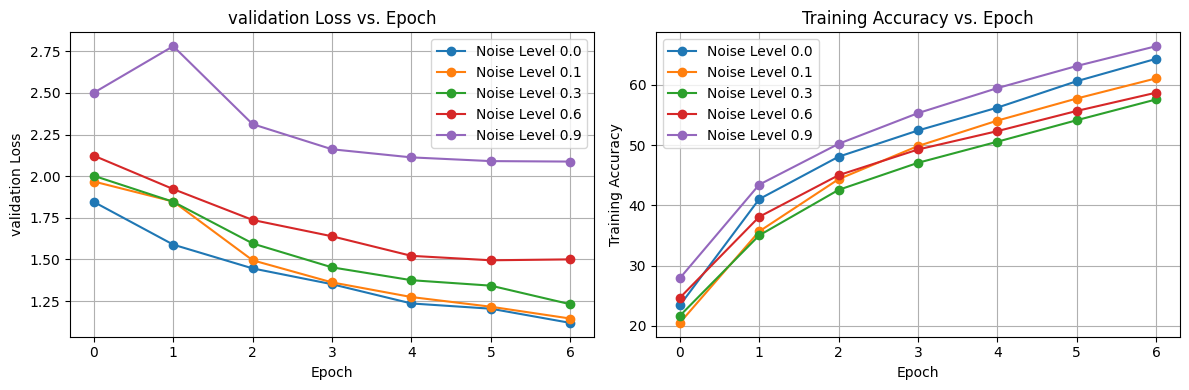

In [ ]:
plot_validation_loss_and_train_accuracy(val_losses,train_accuracies)

In [ ]:
base_asym_test_accuracies,base_asym_testing_times = print_test_output(base_asymmetric_model_dict)

noise_level_0_asy Accuracy: 61.85%, Loss: 1.1085 Testing Time: 2.76 seconds
noise_level_10_asy Accuracy: 59.83%, Loss: 1.1312 Testing Time: 2.73 seconds
noise_level_30_asy Accuracy: 55.80%, Loss: 1.2259 Testing Time: 2.77 seconds
noise_level_60_asy Accuracy: 44.09%, Loss: 1.4839 Testing Time: 2.76 seconds
noise_level_90_asy Accuracy: 41.98%, Loss: 2.0683 Testing Time: 2.71 seconds


# Applying dynamic weights of samples to the BaselineModel

- use compute_sample_weights(), and integrate the weighted loss calculation into the training loop


---



*hyper parameter tuning*

1.   num of epoch
2.   threshold in compute_sample_weights() : Starting with a low threshold and gradually increasing it to observe how the model's performance changes.




In [ ]:
# compute sample weights based on prediction confidence with threshold
def compute_sample_weights(outputs, labels, threshold=0.6):
    confidences, _ = torch.max(nn.functional.softmax(outputs, dim=1), dim=1)
    weights = torch.where(confidences < threshold, torch.tensor(1.0), 1.0 / confidences)
    return weights

## Symmetric

In [ ]:

train_losses = {epsilon: [] for epsilon in noise_levels}
train_accuracies = {epsilon: [] for epsilon in noise_levels}
val_losses = {epsilon: [] for epsilon in noise_levels}
val_accuracies = {epsilon: [] for epsilon in noise_levels}
dw_sym_training_times = {epsilon: [] for epsilon in noise_levels}


# Create a dictionary with keys in the format 'noise_level_{100 * value}'
dw_symmetric_model_dict = {f'noise_level_{int(100 * level)}_sy': None for level in noise_levels}

print("Training with Dynamic weight Model")


for epsilon in noise_levels:


    # Define different model for each nose level
    net = BaselineModel().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=120) # Learning rate scheduler (cosine annealing)

    running_time = 0
    print(f"Symmetric Training with noise level: {epsilon}")

    for epoch in range(num_epochs):
        # Training
        net.train()
        total_train_loss = 0.0
        correct_train = 0
        total_train = 0

        # initialize variables to measure training time
        start_time_train = time.time()


        for inputs, labels in train_loader:
            labels_noisy = torch.from_numpy(apply_label_noise(labels.numpy(), epsilon=epsilon, noise_type='symmetric'))

            # Move data to GPU
            inputs, labels_noisy = inputs.to(device), labels_noisy.to(device)



            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = net(inputs)
            loss = criterion(outputs, labels_noisy)


            # compute sample weights
            weights = compute_sample_weights(outputs, labels_noisy)

            # apply weights to the loss
            weighted_loss = (loss * weights).mean()


            # Backward pass and optimization
            weighted_loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels_noisy.size(0)
            correct_train += (predicted == labels_noisy).sum().item()

        # measure and print epoch training time
        epoch_time = time.time() - start_time_train

        running_time = running_time + epoch_time
        dw_sym_training_times[epsilon].append(running_time)



        average_train_loss = total_train_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train

        # store training metrics
        train_losses[epsilon].append(average_train_loss)
        train_accuracies[epsilon].append(train_acc)


        # update learning rate
        scheduler.step()

        # Validation
        net.eval()
        total_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                # Move data to GPU
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = net(inputs)
                loss = criterion(outputs, labels)

                total_val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        average_val_loss = total_val_loss / len(val_loader)
        val_acc = 100 * correct_val / total_val

        # store validation metrics
        val_losses[epsilon].append(average_val_loss)
        val_accuracies[epsilon].append(val_acc)

        print(f'Epoch {epoch + 1}/{num_epochs}, '
              f'Train Loss: {average_train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, '
              f'Validation Loss: {average_val_loss:.4f}, Validation Accuracy: {val_acc:.2f}')

        # save model to dictionary
        dw_symmetric_model_dict[f'noise_level_{int(100 * epsilon)}_sy'] = net
    print(f'Training Time for {epsilon} : {running_time:.2f} seconds')


Training with Dynamic weight Model
Symmetric Training with noise level: 0.0
Epoch 1/7, Train Loss: 2.1678, Train Accuracy: 20.45%, Validation Loss: 1.9721, Validation Accuracy: 29.15
Epoch 2/7, Train Loss: 1.8460, Train Accuracy: 35.67%, Validation Loss: 1.7725, Validation Accuracy: 40.63
Epoch 3/7, Train Loss: 1.5722, Train Accuracy: 45.82%, Validation Loss: 1.5528, Validation Accuracy: 47.30
Epoch 4/7, Train Loss: 1.3656, Train Accuracy: 52.86%, Validation Loss: 1.4857, Validation Accuracy: 51.39
Epoch 5/7, Train Loss: 1.2240, Train Accuracy: 57.73%, Validation Loss: 1.3130, Validation Accuracy: 56.87
Epoch 6/7, Train Loss: 1.0791, Train Accuracy: 62.85%, Validation Loss: 1.2313, Validation Accuracy: 60.18
Epoch 7/7, Train Loss: 0.9424, Train Accuracy: 67.53%, Validation Loss: 1.1583, Validation Accuracy: 63.17
Training Time for 0.0 : 94.85 seconds
Symmetric Training with noise level: 0.1
Epoch 1/7, Train Loss: 2.2006, Train Accuracy: 18.75%, Validation Loss: 1.9715, Validation Accur

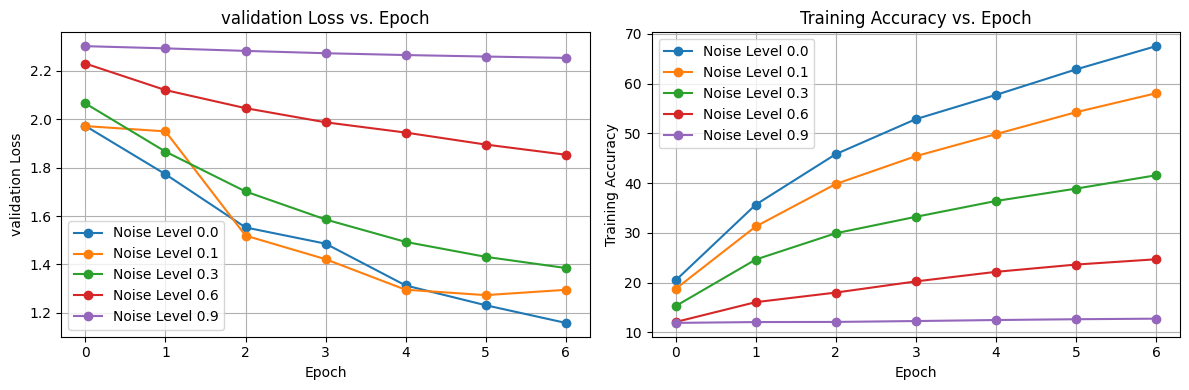

In [ ]:
plot_validation_loss_and_train_accuracy(val_losses,train_accuracies)

In [ ]:
dw_sym_test_accuracies,dw_sym_testing_times = print_test_output(dw_symmetric_model_dict)


noise_level_0_sy Accuracy: 63.22%, Loss: 1.1426 Testing Time: 2.70 seconds
noise_level_10_sy Accuracy: 58.60%, Loss: 1.2864 Testing Time: 2.78 seconds
noise_level_30_sy Accuracy: 52.98%, Loss: 1.3759 Testing Time: 2.88 seconds
noise_level_60_sy Accuracy: 45.33%, Loss: 1.8429 Testing Time: 2.80 seconds
noise_level_90_sy Accuracy: 15.52%, Loss: 2.2540 Testing Time: 2.74 seconds


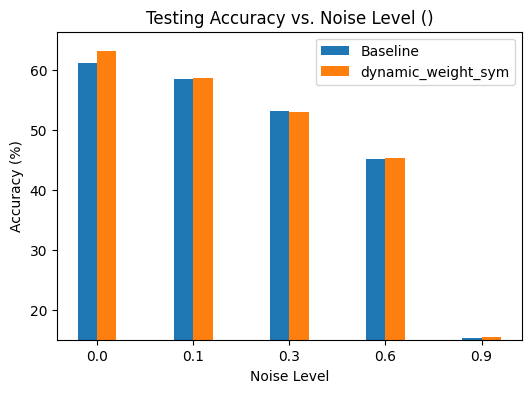

In [ ]:
plot_test_accuracy_compare(dw_sym_test_accuracies, base_sym_test_accuracies,'dynamic_weight_sym')

## Asymmetric

In [ ]:

train_losses = {epsilon: [] for epsilon in noise_levels}
train_accuracies = {epsilon: [] for epsilon in noise_levels}
val_losses = {epsilon: [] for epsilon in noise_levels}
val_accuracies = {epsilon: [] for epsilon in noise_levels}
dw_asym_training_times = {epsilon: [] for epsilon in noise_levels}


# Create a dictionary with keys in the format 'noise_level_{100 * value}'
dw_asymmetric_model_dict = {f'noise_level_{int(100 * level)}_asy': None for level in noise_levels}

print("Training with Baseline Model")


for epsilon in noise_levels:


    # Define different model for each nose level
    net = BaselineModel().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=120) # Learning rate scheduler (cosine annealing)

    running_time = 0
    print(f"Asymmetric Training with noise level: {epsilon}")

    for epoch in range(num_epochs):
        # Training
        net.train()
        total_train_loss = 0.0
        correct_train = 0
        total_train = 0

        # initialize variables to measure training time
        start_time_train = time.time()


        for inputs, labels in train_loader:
            labels_noisy = torch.from_numpy(apply_label_noise(labels.numpy(), epsilon=epsilon, noise_type='asymmetric'))

            # Move data to GPU
            inputs, labels_noisy = inputs.to(device), labels_noisy.to(device)


            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = net(inputs)
            loss = criterion(outputs, labels_noisy)

            # compute sample weights
            weights = compute_sample_weights(outputs, labels_noisy)

            # apply weights to the loss
            weighted_loss = (loss * weights).mean()

            # Backward pass and optimization
            weighted_loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels_noisy.size(0)
            correct_train += (predicted == labels_noisy).sum().item()

        # measure and print epoch training time
        epoch_time = time.time() - start_time_train

        running_time = running_time + epoch_time
        dw_asym_training_times[epsilon].append(running_time)



        average_train_loss = total_train_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train

        # store training metrics
        train_losses[epsilon].append(average_train_loss)
        train_accuracies[epsilon].append(train_acc)


        # update learning rate
        scheduler.step()

        # Validation
        net.eval()
        total_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                # Move data to GPU
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = net(inputs)
                loss = criterion(outputs, labels)

                total_val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        average_val_loss = total_val_loss / len(val_loader)
        val_acc = 100 * correct_val / total_val

        # store validation metrics
        val_losses[epsilon].append(average_val_loss)
        val_accuracies[epsilon].append(val_acc)

        print(f'Epoch {epoch + 1}/{num_epochs}, '
              f'Train Loss: {average_train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, '
              f'Validation Loss: {average_val_loss:.4f}, Validation Accuracy: {val_acc:.2f}')

        # save model to dictionary
        dw_asymmetric_model_dict[f'noise_level_{int(100 * epsilon)}_asy'] = net
    print(f'Training Time for {epsilon} : {running_time:.2f} seconds')

Training with Baseline Model
Asymmetric Training with noise level: 0.0
Epoch 1/7, Train Loss: 2.1548, Train Accuracy: 23.18%, Validation Loss: 1.9564, Validation Accuracy: 32.09
Epoch 2/7, Train Loss: 1.7241, Train Accuracy: 40.81%, Validation Loss: 1.6579, Validation Accuracy: 42.98
Epoch 3/7, Train Loss: 1.5065, Train Accuracy: 48.09%, Validation Loss: 1.4885, Validation Accuracy: 49.06
Epoch 4/7, Train Loss: 1.3407, Train Accuracy: 54.01%, Validation Loss: 1.5368, Validation Accuracy: 50.56
Epoch 5/7, Train Loss: 1.2087, Train Accuracy: 58.65%, Validation Loss: 1.2514, Validation Accuracy: 58.59
Epoch 6/7, Train Loss: 1.0514, Train Accuracy: 63.87%, Validation Loss: 1.1993, Validation Accuracy: 61.97
Epoch 7/7, Train Loss: 0.9241, Train Accuracy: 68.22%, Validation Loss: 1.2304, Validation Accuracy: 62.41
Training Time for 0.0 : 94.44 seconds
Asymmetric Training with noise level: 0.1
Epoch 1/7, Train Loss: 2.1732, Train Accuracy: 20.30%, Validation Loss: 2.0012, Validation Accuracy:

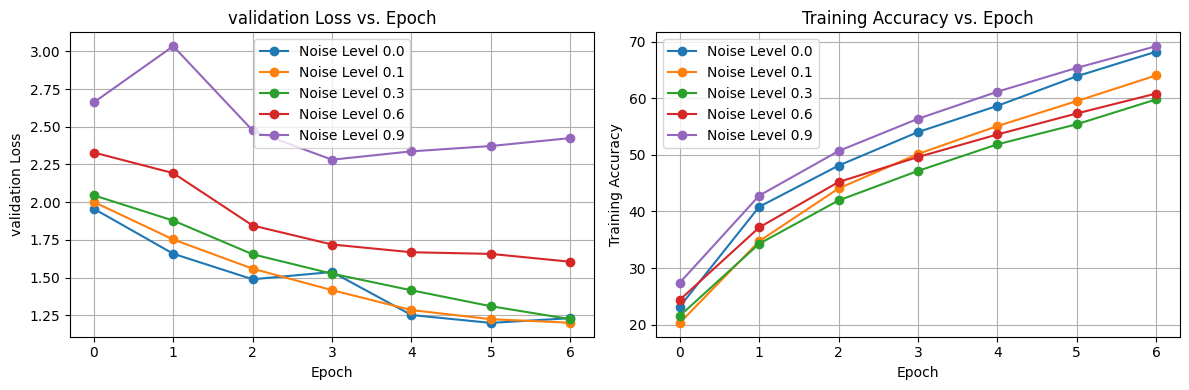

In [ ]:
plot_validation_loss_and_train_accuracy(val_losses,train_accuracies)

In [ ]:
dw_asym_test_accuracies,dw_asymtesting_times = print_test_output(dw_asymmetric_model_dict)

noise_level_0_asy Accuracy: 62.56%, Loss: 1.2138 Testing Time: 2.72 seconds
noise_level_10_asy Accuracy: 60.52%, Loss: 1.1923 Testing Time: 2.77 seconds
noise_level_30_asy Accuracy: 58.35%, Loss: 1.2197 Testing Time: 2.73 seconds
noise_level_60_asy Accuracy: 45.43%, Loss: 1.5996 Testing Time: 2.83 seconds
noise_level_90_asy Accuracy: 41.72%, Loss: 2.4186 Testing Time: 2.68 seconds


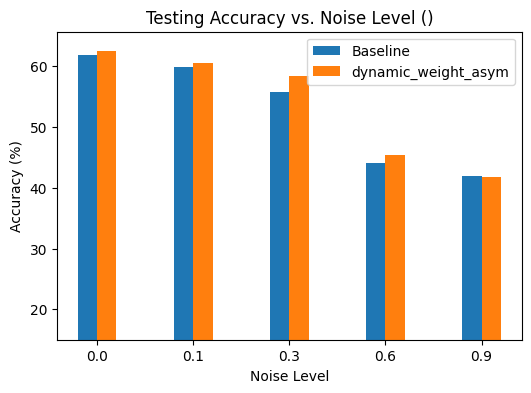

In [ ]:
plot_test_accuracy_compare(dw_asym_test_accuracies, base_asym_test_accuracies,'dynamic_weight_asym')

# Active Passive Loss (APL)



---



---



**1. Active Loss Functions**:
<br> Cross Entropy (CE)
<br> Normalized Cross Entropy (NCE)
<br> Focal Loss (FL)
<br> Normalized Focal Loss (NFL)
<br>


<br> **2. Passive Loss Functions**:
<br> Mean Absolute Error (MAE)
<br> Normalized Mean Absolute Error (NMAE)
<br> Reverse Cross Entropy (RCE)
<br> Normalized Reverse Cross Entropy (NRCE)
<br>



In [ ]:



class APLLoss(nn.Module):
    def __init__(self, alpha, beta, active_func_name , passive_func_name):
        super(APLLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        # Get functions by name
        self.active_loss = getattr(self, active_func_name)
        self.passive_loss = getattr(self, passive_func_name)

    # normalized_cross_entropy
    def nce(self, outputs, targets, epsilon=1e-8):
        pred_prob = F.softmax(outputs, dim=1)
        true_prob = F.one_hot(targets, num_classes=outputs.size(1)).float()
        cross_entropy = -torch.sum(true_prob * torch.log(pred_prob + epsilon), dim=1)
        entropy = -torch.sum(pred_prob * torch.log(pred_prob + epsilon), dim=1)
        nce = torch.mean(cross_entropy / entropy)
        return nce

    # relative_cross_entropy
    def rce(self, outputs, targets, epsilon=1e-8):
        pred_prob = F.softmax(outputs, dim=1)
        true_prob = F.one_hot(targets, num_classes=outputs.size(1)).float()
        cross_entropy = -torch.sum(true_prob * torch.log(pred_prob + epsilon), dim=1)
        return torch.mean(cross_entropy)

    # normalized_focal_loss
    def nfl(self, outputs, targets, gamma=0.5, epsilon=1e-8):
        log_prob = F.log_softmax(outputs, dim=1)
        prob = torch.exp(log_prob)
        focal_loss = -torch.sum((1 - prob) ** gamma * log_prob * F.one_hot(targets, num_classes=outputs.size(1)).float(), dim=1)
        return torch.mean(focal_loss)



    def forward(self, outputs, targets):
        active_loss =  self.active_loss(outputs, targets)
        passive_loss = self.passive_loss(outputs, targets)

        apl_loss = (self.alpha * active_loss) + (self.beta * passive_loss)
        return apl_loss


# hyperparam

In [ ]:
alpha = beta = 1 # ratio of active and passive noise

## APL(nce, rce) + Sym noise

In [ ]:

train_losses = {epsilon: [] for epsilon in noise_levels}
train_accuracies = {epsilon: [] for epsilon in noise_levels}
val_losses = {epsilon: [] for epsilon in noise_levels}
val_accuracies = {epsilon: [] for epsilon in noise_levels}
apl_nce_rce_sym_training_times = {epsilon: [] for epsilon in noise_levels}


apl_criterion = APLLoss(alpha, beta,'nce','rce')
# Create a dictionary with keys in the format 'noise_level_{100 * value}'
apl_nce_rce_symmetric_model_dict = {f'noise_level_{int(100 * level)}_sy': None for level in noise_levels}

print("Training with APL(nce,rce)")

# # Training on GPU
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for epsilon in noise_levels:


    # Define model for each noise level..
    APL_model = BaselineModel().to(device)
    optimizer = optim.SGD(APL_model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=120) # Learning rate scheduler (cosine annealing)

    running_time = 0
    print(f"Symmetric Training with noise level: {epsilon}")

    for epoch in range(num_epochs):
        # Training
        APL_model.train()
        total_train_loss = 0.0
        correct_train = 0
        total_train = 0

        # initialize variables to measure training time
        start_time_train = time.time()


        for inputs, labels in train_loader:
            labels_noisy = torch.from_numpy(apply_label_noise(labels.numpy(), epsilon=epsilon, noise_type='symmetric'))

            # Move data to GPU
            inputs, labels_noisy = inputs.to(device), labels_noisy.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = APL_model(inputs)
            loss = apl_criterion(outputs, labels_noisy)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels_noisy.size(0)
            correct_train += (predicted == labels_noisy).sum().item()

        # measure and print epoch training time
        epoch_time = time.time() - start_time_train

        running_time = running_time + epoch_time
        apl_nce_rce_sym_training_times[epsilon].append(running_time)



        average_train_loss = total_train_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train

        # store training metrics
        train_losses[epsilon].append(average_train_loss)
        train_accuracies[epsilon].append(train_acc)


        # update learning rate
        scheduler.step()

        # Validation
        APL_model.eval()
        total_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                # Move data to GPU
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = APL_model(inputs)
                loss = apl_criterion(outputs, labels)

                total_val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        average_val_loss = total_val_loss / len(val_loader)
        val_acc = 100 * correct_val / total_val

        # store validation metrics
        val_losses[epsilon].append(average_val_loss)
        val_accuracies[epsilon].append(val_acc)

        print(f'Epoch {epoch + 1}/{num_epochs}, '
              f'Train Loss: {average_train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, '
              f'Validation Loss: {average_val_loss:.4f}, Validation Accuracy: {val_acc:.2f}')

        # save model to dictionary
        apl_nce_rce_symmetric_model_dict[f'noise_level_{int(100 * epsilon)}_sy'] = APL_model
    print(f'Training Time for {epsilon} : {running_time:.2f} seconds')

Training with APL(nce,rce)
Symmetric Training with noise level: 0.0
Epoch 1/7, Train Loss: 3.0232, Train Accuracy: 26.42%, Validation Loss: 2.7459, Validation Accuracy: 34.93
Epoch 2/7, Train Loss: 2.4905, Train Accuracy: 43.66%, Validation Loss: 2.4335, Validation Accuracy: 45.18
Epoch 3/7, Train Loss: 2.2705, Train Accuracy: 50.09%, Validation Loss: 2.4006, Validation Accuracy: 47.29
Epoch 4/7, Train Loss: 2.1282, Train Accuracy: 54.47%, Validation Loss: 2.1229, Validation Accuracy: 55.55
Epoch 5/7, Train Loss: 1.9239, Train Accuracy: 60.23%, Validation Loss: 1.9811, Validation Accuracy: 60.10
Epoch 6/7, Train Loss: 1.7540, Train Accuracy: 65.00%, Validation Loss: 1.8861, Validation Accuracy: 63.07
Epoch 7/7, Train Loss: 1.6092, Train Accuracy: 68.67%, Validation Loss: 1.9284, Validation Accuracy: 64.23
Training Time for 0.0 : 94.33 seconds
Symmetric Training with noise level: 0.1
Epoch 1/7, Train Loss: 3.1446, Train Accuracy: 20.58%, Validation Loss: 2.8651, Validation Accuracy: 31.

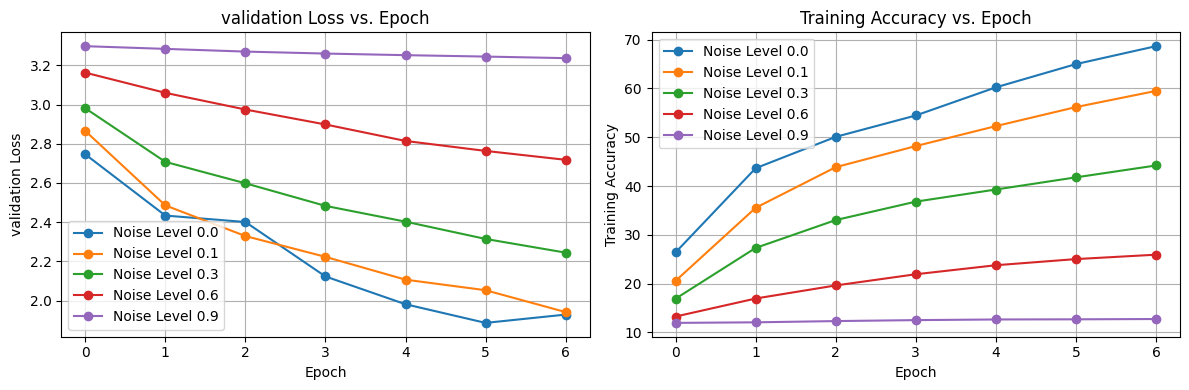

In [ ]:
plot_validation_loss_and_train_accuracy(val_losses,train_accuracies)

In [ ]:
apl_nce_rce_sym_test_accuracies, apl_nce_rce_sym_testing_times = print_test_output(apl_nce_rce_symmetric_model_dict)

noise_level_0_sy Accuracy: 64.73%, Loss: 1.0196 Testing Time: 2.68 seconds
noise_level_10_sy Accuracy: 61.63%, Loss: 1.2073 Testing Time: 2.67 seconds
noise_level_30_sy Accuracy: 55.51%, Loss: 1.4835 Testing Time: 2.69 seconds
noise_level_60_sy Accuracy: 47.49%, Loss: 1.8691 Testing Time: 2.81 seconds
noise_level_90_sy Accuracy: 16.48%, Loss: 2.2546 Testing Time: 2.74 seconds


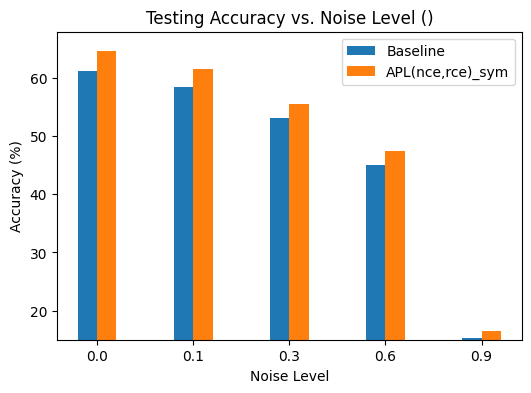

In [ ]:
plot_test_accuracy_compare(apl_nce_rce_sym_test_accuracies, base_sym_test_accuracies,'APL(nce,rce)_sym')

## APL(nce, rce) + asym

In [ ]:

train_losses = {epsilon: [] for epsilon in noise_levels}
train_accuracies = {epsilon: [] for epsilon in noise_levels}
val_losses = {epsilon: [] for epsilon in noise_levels}
val_accuracies = {epsilon: [] for epsilon in noise_levels}
apl_nce_rce_asym_training_timestraining_times = {epsilon: [] for epsilon in noise_levels}


apl_criterion = APLLoss(alpha, beta,'nce','rce')


# Create a dictionary with keys in the format 'noise_level_{100 * value}'
apl_nce_rce_asymmetric_model_dict = {f'noise_level_{int(100 * level)}_asy': None for level in noise_levels}

print("Training with APL(nce,rce)")

# # Training on GPU
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for epsilon in noise_levels:


    # Define model for each noise level..
    APL_model = BaselineModel().to(device)
    optimizer = optim.SGD(APL_model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=120) # Learning rate scheduler (cosine annealing)

    running_time = 0
    print(f"Symmetric Training with noise level: {epsilon}")

    for epoch in range(num_epochs):
        # Training
        APL_model.train()
        total_train_loss = 0.0
        correct_train = 0
        total_train = 0

        # initialize variables to measure training time
        start_time_train = time.time()


        for inputs, labels in train_loader:
            labels_noisy = torch.from_numpy(apply_label_noise(labels.numpy(), epsilon=epsilon, noise_type='asymmetric'))

            # Move data to GPU
            inputs, labels_noisy = inputs.to(device), labels_noisy.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = APL_model(inputs)
            loss = apl_criterion(outputs, labels_noisy)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels_noisy.size(0)
            correct_train += (predicted == labels_noisy).sum().item()

        # measure and print epoch training time
        epoch_time = time.time() - start_time_train

        running_time = running_time + epoch_time
        apl_nce_rce_asym_training_timestraining_times[epsilon].append(running_time)



        average_train_loss = total_train_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train

        # store training metrics
        train_losses[epsilon].append(average_train_loss)
        train_accuracies[epsilon].append(train_acc)


        # update learning rate
        scheduler.step()

        # Validation
        APL_model.eval()
        total_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                # Move data to GPU
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = APL_model(inputs)
                loss = apl_criterion(outputs, labels)

                total_val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        average_val_loss = total_val_loss / len(val_loader)
        val_acc = 100 * correct_val / total_val

        # store validation metrics
        val_losses[epsilon].append(average_val_loss)
        val_accuracies[epsilon].append(val_acc)

        print(f'Epoch {epoch + 1}/{num_epochs}, '
              f'Train Loss: {average_train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, '
              f'Validation Loss: {average_val_loss:.4f}, Validation Accuracy: {val_acc:.2f}')

        # save model to dictionary
        apl_nce_rce_asymmetric_model_dict[f'noise_level_{int(100 * epsilon)}_asy'] = APL_model
    print(f'Training Time for {epsilon} : {running_time:.2f} seconds')

Training with APL(nce,rce)
Symmetric Training with noise level: 0.0
Epoch 1/7, Train Loss: 3.0232, Train Accuracy: 26.46%, Validation Loss: 2.7421, Validation Accuracy: 34.96
Epoch 2/7, Train Loss: 2.4924, Train Accuracy: 43.68%, Validation Loss: 2.4014, Validation Accuracy: 45.90
Epoch 3/7, Train Loss: 2.2660, Train Accuracy: 50.20%, Validation Loss: 2.3979, Validation Accuracy: 47.56
Epoch 4/7, Train Loss: 2.1275, Train Accuracy: 54.65%, Validation Loss: 2.1055, Validation Accuracy: 55.76
Epoch 5/7, Train Loss: 1.9266, Train Accuracy: 60.36%, Validation Loss: 1.9939, Validation Accuracy: 59.79
Epoch 6/7, Train Loss: 1.7619, Train Accuracy: 65.03%, Validation Loss: 1.9435, Validation Accuracy: 62.05
Epoch 7/7, Train Loss: 1.6217, Train Accuracy: 68.43%, Validation Loss: 2.1716, Validation Accuracy: 60.25
Training Time for 0.0 : 93.33 seconds
Symmetric Training with noise level: 0.1
Epoch 1/7, Train Loss: 3.1031, Train Accuracy: 22.27%, Validation Loss: 2.8479, Validation Accuracy: 31.

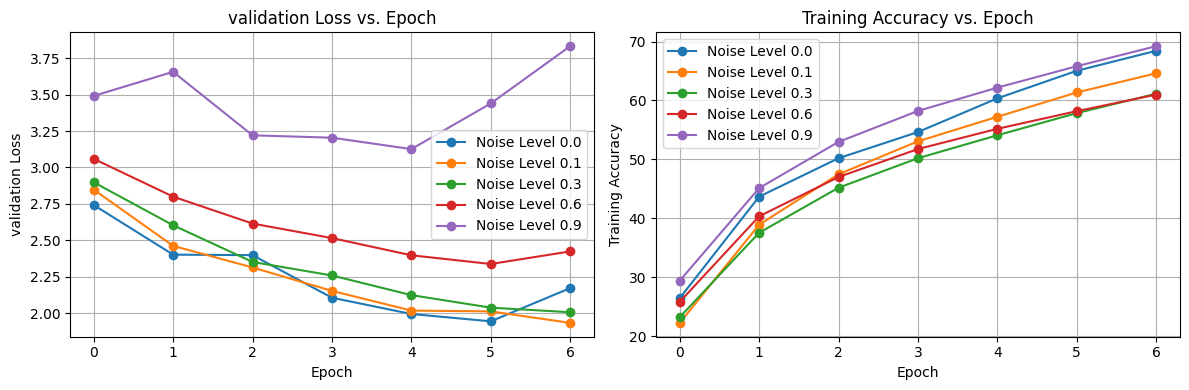

In [ ]:
plot_validation_loss_and_train_accuracy(val_losses,train_accuracies)

### Testing

In [ ]:
apl_nce_rce_asym_test_accuracies, apl_nce_rce_asym_testing_times = print_test_output(apl_nce_rce_asymmetric_model_dict)

noise_level_0_asy Accuracy: 60.11%, Loss: 1.1314 Testing Time: 2.70 seconds
noise_level_10_asy Accuracy: 61.48%, Loss: 1.1089 Testing Time: 2.75 seconds
noise_level_30_asy Accuracy: 57.80%, Loss: 1.1776 Testing Time: 2.89 seconds
noise_level_60_asy Accuracy: 45.03%, Loss: 1.3880 Testing Time: 2.73 seconds
noise_level_90_asy Accuracy: 42.10%, Loss: 1.7988 Testing Time: 2.79 seconds


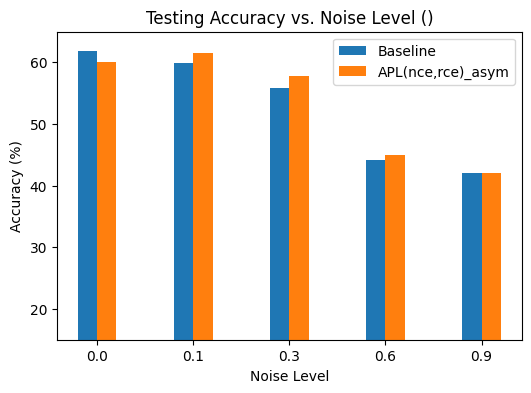

In [ ]:
plot_test_accuracy_compare(apl_nce_rce_asym_test_accuracies, base_asym_test_accuracies,'APL(nce,rce)_asym')

## APL(nfl, rce) + Sym

In [ ]:

train_losses = {epsilon: [] for epsilon in noise_levels}
train_accuracies = {epsilon: [] for epsilon in noise_levels}
val_losses = {epsilon: [] for epsilon in noise_levels}
val_accuracies = {epsilon: [] for epsilon in noise_levels}
apl_nfl_rce_sym_training_times = {epsilon: [] for epsilon in noise_levels}



apl_criterion = APLLoss(alpha, beta,'nfl','rce')

# Create a dictionary with keys in the format 'noise_level_{100 * value}'
apl_nfl_rce_symmetric_model_dict = {f'noise_level_{int(100 * level)}_sy': None for level in noise_levels}

print("Training with APL(nfl,rce)")

# # Training on GPU
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for epsilon in noise_levels:


    # Define model for each noise level..
    APL_model = BaselineModel().to(device)
    optimizer = optim.SGD(APL_model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=120) # Learning rate scheduler (cosine annealing)

    running_time = 0
    print(f"Symmetric Training with noise level: {epsilon}")

    for epoch in range(num_epochs):
        # Training
        APL_model.train()
        total_train_loss = 0.0
        correct_train = 0
        total_train = 0

        # initialize variables to measure training time
        start_time_train = time.time()


        for inputs, labels in train_loader:
            labels_noisy = torch.from_numpy(apply_label_noise(labels.numpy(), epsilon=epsilon, noise_type='symmetric'))

            # Move data to GPU
            inputs, labels_noisy = inputs.to(device), labels_noisy.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = APL_model(inputs)
            loss = apl_criterion(outputs, labels_noisy)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels_noisy.size(0)
            correct_train += (predicted == labels_noisy).sum().item()

        # measure and print epoch training time
        epoch_time = time.time() - start_time_train

        running_time = running_time + epoch_time
        apl_nfl_rce_sym_training_times[epsilon].append(running_time)



        average_train_loss = total_train_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train

        # store training metrics
        train_losses[epsilon].append(average_train_loss)
        train_accuracies[epsilon].append(train_acc)


        # update learning rate
        scheduler.step()

        # Validation
        APL_model.eval()
        total_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                # Move data to GPU
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = APL_model(inputs)
                loss = apl_criterion(outputs, labels)

                total_val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        average_val_loss = total_val_loss / len(val_loader)
        val_acc = 100 * correct_val / total_val

        # store validation metrics
        val_losses[epsilon].append(average_val_loss)
        val_accuracies[epsilon].append(val_acc)

        print(f'Epoch {epoch + 1}/{num_epochs}, '
              f'Train Loss: {average_train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, '
              f'Validation Loss: {average_val_loss:.4f}, Validation Accuracy: {val_acc:.2f}')

        # save model to dictionary
        apl_nfl_rce_symmetric_model_dict[f'noise_level_{int(100 * epsilon)}_sy'] = APL_model
    print(f'Training Time for {epsilon} : {running_time:.2f} seconds')

Training with APL(nfl,rce)
Symmetric Training with noise level: 0.0
Epoch 1/7, Train Loss: 3.8507, Train Accuracy: 27.98%, Validation Loss: 3.3131, Validation Accuracy: 38.33
Epoch 2/7, Train Loss: 2.8541, Train Accuracy: 46.20%, Validation Loss: 3.0402, Validation Accuracy: 42.87
Epoch 3/7, Train Loss: 2.4943, Train Accuracy: 52.97%, Validation Loss: 2.9761, Validation Accuracy: 46.74
Epoch 4/7, Train Loss: 2.2026, Train Accuracy: 58.40%, Validation Loss: 2.2660, Validation Accuracy: 58.29
Epoch 5/7, Train Loss: 1.8581, Train Accuracy: 64.95%, Validation Loss: 2.2051, Validation Accuracy: 60.05
Epoch 6/7, Train Loss: 1.5847, Train Accuracy: 70.22%, Validation Loss: 2.0613, Validation Accuracy: 62.91
Epoch 7/7, Train Loss: 1.3504, Train Accuracy: 74.50%, Validation Loss: 2.2722, Validation Accuracy: 62.55
Training Time for 0.0 : 92.83 seconds
Symmetric Training with noise level: 0.1
Epoch 1/7, Train Loss: 4.1177, Train Accuracy: 21.60%, Validation Loss: 3.5068, Validation Accuracy: 34.

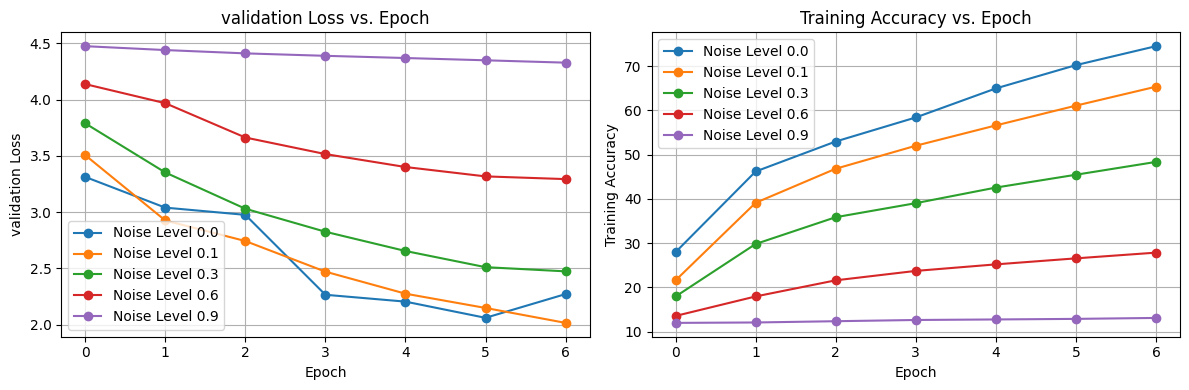

In [ ]:
plot_validation_loss_and_train_accuracy(val_losses,train_accuracies)

In [ ]:
apl_nfl_rce_sym_test_accuracies,apl_nfl_rce_sym_testing_times = print_test_output(apl_nfl_rce_symmetric_model_dict)

noise_level_0_sy Accuracy: 62.46%, Loss: 1.1804 Testing Time: 2.70 seconds
noise_level_10_sy Accuracy: 63.69%, Loss: 1.0695 Testing Time: 2.83 seconds
noise_level_30_sy Accuracy: 56.73%, Loss: 1.3085 Testing Time: 2.67 seconds
noise_level_60_sy Accuracy: 49.15%, Loss: 1.7195 Testing Time: 2.65 seconds
noise_level_90_sy Accuracy: 18.97%, Loss: 2.2254 Testing Time: 2.71 seconds


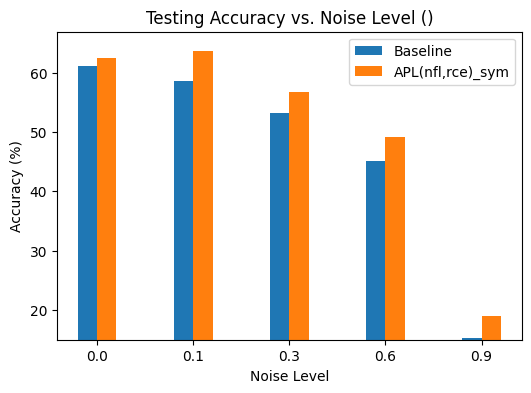

In [ ]:
plot_test_accuracy_compare(apl_nfl_rce_sym_test_accuracies, base_sym_test_accuracies,'APL(nfl,rce)_sym')

## APL(nfl, rce) + asym

In [ ]:

train_losses = {epsilon: [] for epsilon in noise_levels}
train_accuracies = {epsilon: [] for epsilon in noise_levels}

val_losses = {epsilon: [] for epsilon in noise_levels}
val_accuracies = {epsilon: [] for epsilon in noise_levels}
apl_nfl_rce_asym_training_times = {epsilon: [] for epsilon in noise_levels}



apl_criterion = APLLoss(alpha, beta,'nce','rce')



# Create a dictionary with keys in the format 'noise_level_{100 * value}'
apl_nfl_rce_asymmetric_model_dict = {f'noise_level_{int(100 * level)}_asy': None for level in noise_levels}

print("Training with APL(nfl,rce)")

# # Training on GPU
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for epsilon in noise_levels:


    # Define model for each noise level..
    APL_model = BaselineModel().to(device)
    optimizer = optim.SGD(APL_model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=120) # Learning rate scheduler (cosine annealing)

    running_time = 0
    print(f"Asymmetric Training with noise level: {epsilon}")

    for epoch in range(num_epochs):
        # Training
        APL_model.train()
        total_train_loss = 0.0
        correct_train = 0
        total_train = 0


        # initialize variables to measure training time
        start_time_train = time.time()

        for inputs, labels in train_loader:
            labels_noisy = torch.from_numpy(apply_label_noise(labels.numpy(), epsilon=epsilon, noise_type='asymmetric'))

            # Move data to GPU
            inputs, labels_noisy = inputs.to(device), labels_noisy.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = APL_model(inputs)
            loss = apl_criterion(outputs, labels_noisy)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels_noisy.size(0)
            correct_train += (predicted == labels_noisy).sum().item()


        # measure and print epoch training time
        epoch_time = time.time() - start_time_train
        running_time = running_time + epoch_time
        apl_nfl_rce_asym_training_times[epsilon].append(running_time)

        average_train_loss = total_train_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train

        # store training metrics
        train_losses[epsilon].append(average_train_loss)
        train_accuracies[epsilon].append(train_acc)


        scheduler.step()

        # Validation
        APL_model.eval()
        total_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                # Move data to GPU
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = APL_model(inputs)
                loss = apl_criterion(outputs, labels)

                total_val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        average_val_loss = total_val_loss / len(val_loader)
        val_acc = 100 * correct_val / total_val

        # store validation metrics
        val_losses[epsilon].append(average_val_loss)
        val_accuracies[epsilon].append(val_acc)

        print(f'Epoch {epoch + 1}/{num_epochs}, '
              f'Train Loss: {average_train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, '
              f'Validation Loss: {average_val_loss:.4f}, Validation Accuracy: {val_acc:.2f}')
        # save model to dictionary
        apl_nfl_rce_asymmetric_model_dict[f'noise_level_{int(100 * epsilon)}_asy'] = APL_model
    print(f'Training Time for {epsilon} : {running_time:.2f} seconds')


Training with APL(nfl,rce)
Asymmetric Training with noise level: 0.0
Epoch 1/7, Train Loss: 3.0230, Train Accuracy: 26.44%, Validation Loss: 2.7504, Validation Accuracy: 34.93
Epoch 2/7, Train Loss: 2.4912, Train Accuracy: 43.66%, Validation Loss: 2.4342, Validation Accuracy: 45.09
Epoch 3/7, Train Loss: 2.2726, Train Accuracy: 50.09%, Validation Loss: 2.2931, Validation Accuracy: 50.09
Epoch 4/7, Train Loss: 2.1207, Train Accuracy: 54.80%, Validation Loss: 2.0987, Validation Accuracy: 55.68
Epoch 5/7, Train Loss: 1.9220, Train Accuracy: 60.35%, Validation Loss: 2.0297, Validation Accuracy: 59.04
Epoch 6/7, Train Loss: 1.7599, Train Accuracy: 64.84%, Validation Loss: 1.9383, Validation Accuracy: 61.59
Epoch 7/7, Train Loss: 1.6024, Train Accuracy: 68.82%, Validation Loss: 1.9921, Validation Accuracy: 61.18
Training Time for 0.0 : 94.07 seconds
Asymmetric Training with noise level: 0.1
Epoch 1/7, Train Loss: 3.1033, Train Accuracy: 22.25%, Validation Loss: 2.8483, Validation Accuracy: 3

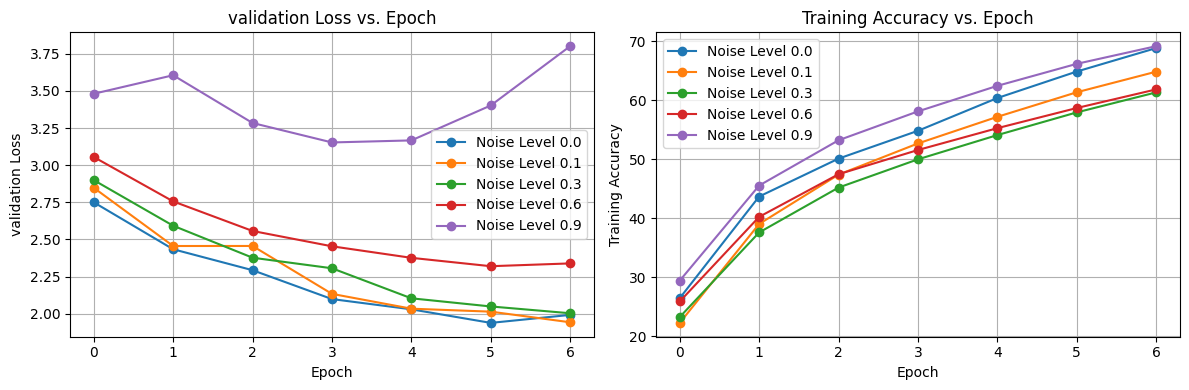

In [ ]:
plot_validation_loss_and_train_accuracy(val_losses,train_accuracies)

### Testing

In [ ]:
apl_nfl_rce_asym_test_accuracies, apl_nfl_rce_asym_testing_times = print_test_output(apl_nfl_rce_asymmetric_model_dict)

noise_level_0_asy Accuracy: 62.57%, Loss: 1.0813 Testing Time: 2.74 seconds
noise_level_10_asy Accuracy: 61.67%, Loss: 1.1023 Testing Time: 2.68 seconds
noise_level_30_asy Accuracy: 58.18%, Loss: 1.1764 Testing Time: 2.75 seconds
noise_level_60_asy Accuracy: 46.97%, Loss: 1.3258 Testing Time: 2.73 seconds
noise_level_90_asy Accuracy: 42.08%, Loss: 1.8149 Testing Time: 2.71 seconds


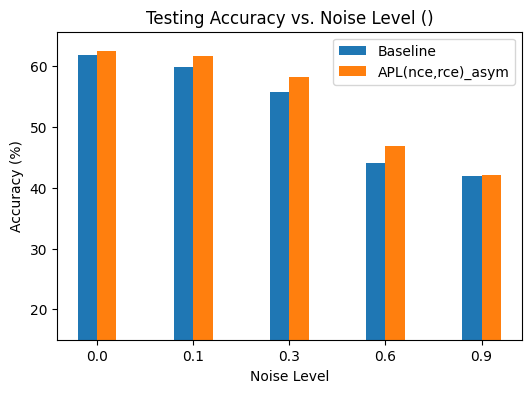

In [ ]:
plot_test_accuracy_compare(apl_nfl_rce_asym_test_accuracies, base_asym_test_accuracies,'APL(nce,rce)_asym')

# Testing with MNIST dataset

In [ ]:
from torchvision.datasets import MNIST
imagenet_mean = (0.485, 0.456, 0.406)
imagenet_std = (0.229, 0.224, 0.225)

# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize MNIST images to match CIFAR-10 size
    transforms.Grayscale(num_output_channels=3),  # Convert MNIST images to RGB
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)  # Normalize
])


# Download the MNIST testing dataset
mnist_test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)

# Create DataLoader for training and testing datasets
mnist_test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)


100%|██████████| 9912422/9912422 [00:00<00:00, 76937204.48it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 32721689.31it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 21427216.95it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4766206.85it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## models

In [ ]:
dw_asym_30_model = dw_asymmetric_model_dict['noise_level_30_asy'].eval()


In [ ]:
apl_nce_rce_sym_60_model = apl_nce_rce_symmetric_model_dict['noise_level_60_sy'].eval()

In [ ]:
apl_nfl_rce_sym_60_model = apl_nfl_rce_symmetric_model_dict['noise_level_60_sy'].eval()

### Evaluate

In [ ]:
def test_mnist(model, mnist_test_loader=mnist_test_loader):
    # Evaluate the CIFAR-10 model on the MNIST test set
    with torch.no_grad():
        correct = 0
        total = 0
        for data, labels in mnist_test_loader:
            data = data.to(device, dtype=torch.float32)
            labels = labels.to(device, dtype=torch.long)
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f'Accuracy on MNIST test set: {accuracy * 100:.2f}%')

In [ ]:
print(f'>> Dynamic weight asymmetric noise level 30 model')
test_mnist(dw_asym_30_model)

>> Dynamic weight asymmetric noise level 30 model
Accuracy on MNIST test set: 58.35%


In [ ]:
print(f'>> APL(nce,rce) symmetric noise level 60 model')
test_mnist(apl_nce_rce_sym_60_model)

>> APL(nce,rce) symmetric noise level 60 model
Accuracy on MNIST test set: 47.49%


In [ ]:
print(f'>> APL(nfl,rce) symmetric noise level 60 model')
test_mnist(apl_nfl_rce_sym_60_model)

>> APL(nfl,rce) symmetric noise level 60 model
Accuracy on MNIST test set: 49.15%


# Test Accuracies comparison table

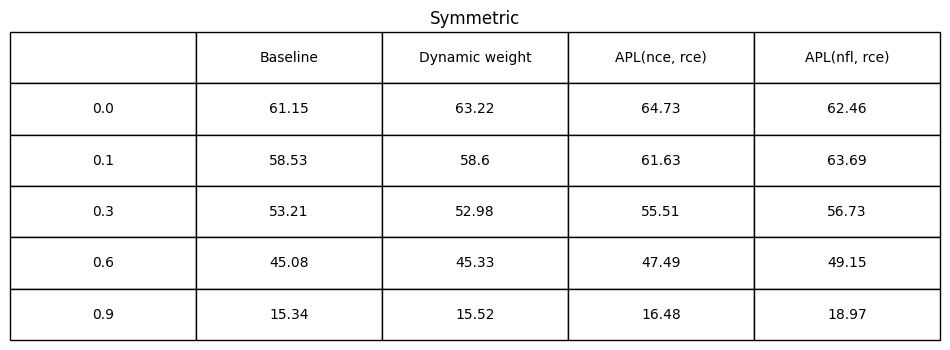

In [ ]:
import pandas as pd

# Example lists of float values
list1 = base_sym_test_accuracies
list2 = dw_sym_test_accuracies
list3 = apl_nce_rce_sym_test_accuracies
list4 = apl_nfl_rce_sym_test_accuracies

# Create a DataFrame
df = pd.DataFrame({'':noise_levels,'Baseline': list1, 'Dynamic weight': list2, 'APL(nce, rce)': list3 , 'APL(nfl, rce)': list4})
df = df.round(2)

# Display the DataFrame with a grid using matplotlib
fig, ax = plt.subplots(figsize=(12, 4))  # Adjust the figure size if needed
ax.axis('tight')
ax.axis('off')
ax.set_title("Symmetric")
ax.table(cellText=df.values, colLabels=df.columns, cellLoc = 'center', loc='center', cellColours=None, bbox=[0, 0, 1, 1])
plt.show()


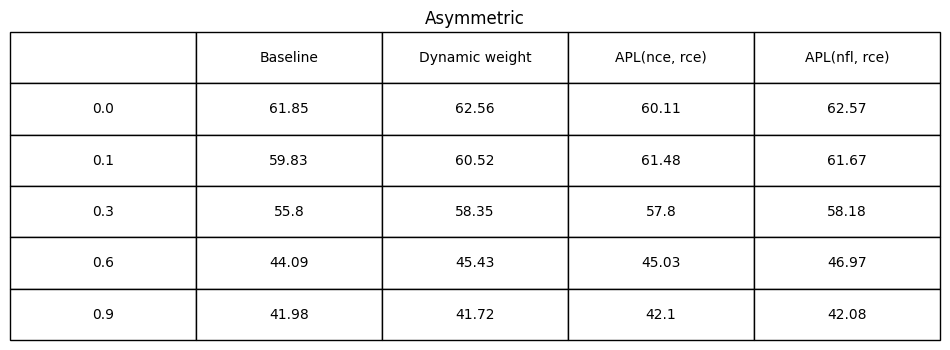

In [ ]:
# Example lists of float values
list1 = base_asym_test_accuracies
list2 = dw_asym_test_accuracies
list3 = apl_nce_rce_asym_test_accuracies
list4 = apl_nfl_rce_asym_test_accuracies

# Create a DataFrame
df = pd.DataFrame({'':noise_levels,'Baseline': list1, 'Dynamic weight': list2, 'APL(nce, rce)': list3 , 'APL(nfl, rce)': list4})
df = df.round(2)

# Display the DataFrame with a grid using matplotlib
fig, ax = plt.subplots(figsize=(12, 4))  # Adjust the figure size if needed
ax.axis('tight')
ax.axis('off')
ax.set_title("Asymmetric")
ax.table(cellText=df.values, colLabels=df.columns, cellLoc = 'center', loc='center', cellColours=None, bbox=[0, 0, 1, 1])
plt.show()